<a href="https://colab.research.google.com/github/jjwjjwjjwjjwjjw/Recommender-System/blob/main/2_%ED%98%91%EC%97%85%ED%95%84%ED%84%B0%EB%A7%81_(%EB%AA%A8%EB%8D%B8%EA%B8%B0%EB%B0%98)_Matrix_Factorization_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Matrix Factorization

- MovieLens 데이터셋 활용하기
- SVD를 직접 구현하고, 적절한 k값 찾기
- matrix factorization을 간단히 할 수 있는 파이썬 라이브러리 소개

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
from math import sqrt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Dataset 불러오기

In [ ]:
# 각자 작업 환경에 맞는 경로를 지정해주세요. Google Colab과 Jupyter환경에서 경로가 다를 수 있습니다.
path = '/content/drive/MyDrive/data/movielens'
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding='utf-8')

print(ratings_df.shape)
print(ratings_df.head())

(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [ ]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)

print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


### Sparse Matrix 만들기

In [ ]:
sparse_matrix = train_df.groupby('movieId').apply(lambda x: pd.Series(x['rating'].values, index=x['userId'])).unstack()
sparse_matrix.index.name = 'movieId'

sparse_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,NaN,2.5,NaN,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,NaN,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# fill sparse matrix with average of movie ratings
sparse_matrix_withmovie = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

# fill sparse matrix with average of user ratings
sparse_matrix_withuser = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=0)

In [ ]:
sparse_matrix_withmovie.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,3.893491,3.893491,3.893491,3.893491,4.000000,3.893491,4.500000,3.893491,3.893491,3.893491,...,4.000000,3.893491,4.000000,3.000000,4.000000,2.500000,3.893491,2.500000,3.893491,5.000000
2,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,4.000000,3.396341,3.396341,...,3.396341,4.000000,3.396341,3.396341,3.500000,3.396341,3.396341,2.000000,3.396341,3.396341
3,4.000000,3.454545,3.454545,3.454545,3.454545,5.000000,3.454545,3.454545,3.454545,3.454545,...,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545
4,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,...,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000
5,3.039474,3.039474,3.039474,3.039474,3.039474,5.000000,3.039474,3.039474,3.039474,3.039474,...,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474


In [ ]:
sparse_matrix_withuser.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.320652,3.94,2.516667,3.631868,4.000000,3.504132,4.500000,3.486486,3.1,3.292035,...,4.000000,3.473684,4.000000,3.000000,4.000000,2.500000,3.772414,2.500000,3.275862,5.000000
2,4.320652,3.94,2.516667,3.631868,3.636364,3.504132,3.247967,4.000000,3.1,3.292035,...,4.396104,4.000000,3.494024,3.486842,3.500000,3.649718,3.772414,2.000000,3.275862,3.678709
3,4.000000,3.94,2.516667,3.631868,3.636364,5.000000,3.247967,3.486486,3.1,3.292035,...,4.396104,3.473684,3.494024,3.486842,3.255618,3.649718,3.772414,3.145865,3.275862,3.678709
4,4.320652,3.94,2.516667,3.631868,3.636364,3.504132,3.247967,3.486486,3.1,3.292035,...,4.396104,3.473684,3.494024,3.486842,3.255618,3.649718,3.772414,3.145865,3.275862,3.678709
5,4.320652,3.94,2.516667,3.631868,3.636364,5.000000,3.247967,3.486486,3.1,3.292035,...,4.396104,3.473684,3.494024,3.486842,3.255618,3.649718,3.772414,3.145865,3.275862,3.678709


## Matrix Factorization with SVD

In [ ]:
def get_svd(s_matrix, k=300):
  u, s, vh = np.linalg.svd(s_matrix.transpose())
  S = s[:k] * np.identity(k, np.float)
  T = u[:,:k]
  Dt = vh[:k,:]

  item_factors = np.transpose(np.matmul(S, Dt))
  user_factors = np.transpose(T)

  return item_factors, user_factors

### 1. with average movie ratings

In [ ]:
item_factors, user_factors = get_svd(sparse_matrix_withmovie)
prediction_result_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix_withmovie.columns.values, index=sparse_matrix_withmovie.index.values)

movie_prediction_result_df = prediction_result_df.transpose()

<ipython-input-9-a1d4ca065b40>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)


In [ ]:
print(item_factors.shape)
print(user_factors.shape)

(8938, 300)
(300, 610)


8938 X 610 = (8938 X 300) (300 X 300) (300 X 610)

In [ ]:
movie_prediction_result_df.head()

,1,2,3,4,5,6,7,8,9,10,...,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
1,3.908820,3.390957,4.035030,2.252912,3.053903,3.981066,3.183727,2.744891,2.909088,3.505548,...,0.999983,4.499925,3.499942,2.999950,3.999934,3.999934,3.499942,3.999934,3.499942,3.999934
2,3.911434,3.445683,3.461056,2.240729,2.998555,3.959505,3.151831,2.751379,2.910568,3.406105,...,0.999942,4.499739,3.499797,2.999826,3.999768,3.999768,3.499797,3.999768,3.499797,3.999768
3,3.896327,3.383747,3.439498,2.240612,3.049043,3.935766,3.174809,2.738581,2.910505,3.515399,...,1.000001,4.500004,3.500003,3.000003,4.000004,4.000004,3.500003,4.000004,3.500003,4.000004
4,3.881024,3.421886,3.427186,2.239842,3.057280,3.946683,3.197075,2.748549,2.921073,3.513596,...,0.999981,4.499913,3.499933,2.999942,3.999923,3.999923,3.499933,3.999923,3.499933,3.999923
5,4.018416,3.400912,3.493598,2.184629,3.156865,3.946429,3.246271,2.874286,2.903455,3.256205,...,1.000034,4.500155,3.500120,3.000103,4.000138,4.000138,3.500120,4.000138,3.500120,4.000138


### 2. with average user ratings

In [ ]:
item_factors, user_factors = get_svd(sparse_matrix_withuser)
prediction_result_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix_withuser.columns.values, index=sparse_matrix_withuser.index.values)

user_prediction_result_df = prediction_result_df.transpose()

<ipython-input-9-a1d4ca065b40>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)


In [ ]:
user_prediction_result_df.head()

,1,2,3,4,5,6,7,8,9,10,...,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
1,4.362666,4.366280,3.966290,4.335373,4.363704,3.983660,4.303573,4.339269,4.305649,4.254211,...,4.318208,4.320182,4.320834,4.321160,4.320508,4.320508,4.320834,4.320508,4.320834,4.321664
2,4.018066,3.941879,3.903070,3.960808,3.907779,3.993262,3.913604,3.941605,3.919774,3.880579,...,3.924886,3.945287,3.937965,3.934304,3.941626,3.941626,3.937965,3.941626,3.937965,3.940416
3,2.503743,2.498854,2.491555,2.529266,2.509395,2.519116,2.486491,2.511599,2.508844,2.517707,...,2.526417,2.516350,2.516789,2.517009,2.516569,2.516569,2.516789,2.516569,2.516789,2.516032
4,3.624253,3.635961,3.619964,3.641844,3.632798,3.643807,3.636671,3.642801,3.615370,3.632327,...,3.631674,3.632685,3.631554,3.630989,3.632119,3.632119,3.631554,3.632119,3.631554,3.632004
5,4.051183,3.581114,3.721059,3.627674,3.519383,3.536805,3.768194,3.682646,3.571370,3.639438,...,3.586132,3.638168,3.635671,3.634422,3.636919,3.636919,3.635671,3.636919,3.635671,3.637667


In [ ]:
item_factors.shape

(8938, 300)

## Compare user and movie scenario

In [ ]:
def evaluate(test_df, prediction_result_df):
  groups_with_movie_ids = test_df.groupby(by='movieId')
  groups_with_user_ids = test_df.groupby(by='userId')
  intersection_movie_ids = sorted(list(set(list(prediction_result_df.columns)).intersection(set(list(groups_with_movie_ids.indices.keys())))))
  intersection_user_ids = sorted(list(set(list(prediction_result_df.index)).intersection(set(groups_with_user_ids.indices.keys()))))

  print(len(intersection_movie_ids))
  print(len(intersection_user_ids))

  compressed_prediction_df = prediction_result_df.loc[intersection_user_ids][intersection_movie_ids]

  # test_df에 대해서 RMSE 계산
  grouped = test_df.groupby(by='userId')
  rmse_df = pd.DataFrame(columns=['rmse'])
  for userId, group in tqdm(grouped):
      if userId in intersection_user_ids:
          pred_ratings = compressed_prediction_df.loc[userId][compressed_prediction_df.loc[userId].index.intersection(list(group['movieId'].values))]
          pred_ratings = pred_ratings.to_frame(name='rating').reset_index().rename(columns={'index':'movieId','rating':'pred_rating'})
          actual_ratings = group[['rating', 'movieId']].rename(columns={'rating':'actual_rating'})

          final_df = pd.merge(actual_ratings, pred_ratings, how='inner', on=['movieId'])
          final_df = final_df.round(4) # 반올림

          if not final_df.empty:
            rmse = sqrt(mean_squared_error(final_df['actual_rating'], final_df['pred_rating']))
            rmse_df.loc[userId] = rmse

  return final_df, rmse_df

In [ ]:
result_df, _ = evaluate(test_df, user_prediction_result_df)
print(result_df)
print("For user matrix")
print(f"RMSE: {sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))}")

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

     actual_rating  movieId  pred_rating
0              5.0     3527       3.6789
1              3.5    84772       3.6783
2              3.5   103141       3.6758
3              4.0    81132       3.6785
4              4.5   130634       3.6785
..             ...      ...          ...
218            4.0   106100       3.6805
219            4.0   111759       3.6747
220            1.0     4852       3.6787
221            3.0     2628       3.6883
222            5.0     1953       3.6721

[223 rows x 3 columns]
For user matrix
RMSE: 0.8551691150767583


In [ ]:
result_df, _ = evaluate(test_df, movie_prediction_result_df)
print(result_df)
print("For movie matrix")
print(f"RMSE: {sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))}")

4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

     actual_rating  movieId  pred_rating
0              5.0     3527       3.6030
1              3.5    84772       3.0433
2              3.5   103141       4.0453
3              4.0    81132       3.5000
4              4.5   130634       3.2496
..             ...      ...          ...
218            4.0   106100       3.8314
219            4.0   111759       3.9239
220            1.0     4852       1.0000
221            3.0     2628       3.1901
222            5.0     1953       3.8234

[223 rows x 3 columns]
For movie matrix
RMSE: 0.8209361471321392


## Experiments on different k

In [ ]:
def find_best_k(sparse_matrix, maximum_k=100):
    print("\nFind best optimized k for Matrix Factorization")
    k_candidates = np.arange(50, maximum_k, 10)
    final_df = pd.DataFrame(columns=['rmse'], index=k_candidates)
    for k in tqdm(k_candidates):
        item_factors, user_factors = get_svd(sparse_matrix, k)
        each_results_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix.columns.values, index=sparse_matrix.index.values)
        each_results_df = each_results_df.transpose()

        result_df, _ = evaluate(test_df, each_results_df)
        each_rmse = sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))

        final_df.loc[k]['rmse'] = each_rmse

    return final_df


grid search (or coordinate search)

In [ ]:
res = find_best_k(sparse_matrix_withmovie, 200)


Find best optimized k for Matrix Factorization


<ipython-input-19-eee70a464fbe>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm(k_candidates):


  0%|          | 0/15 [00:00<?, ?it/s]

4385
610


<ipython-input-9-a1d4ca065b40>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)
<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-9-a1d4ca065b40>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)
<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

<ipython-input-9-a1d4ca065b40>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)
<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-9-a1d4ca065b40>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)
<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-9-a1d4ca065b40>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)
<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-9-a1d4ca065b40>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)
<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-9-a1d4ca065b40>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)
<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

<ipython-input-9-a1d4ca065b40>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)


4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-9-a1d4ca065b40>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)
<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-9-a1d4ca065b40>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)
<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-9-a1d4ca065b40>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)
<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-9-a1d4ca065b40>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)
<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-9-a1d4ca065b40>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)
<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

<ipython-input-9-a1d4ca065b40>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)


4385
610


<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


<ipython-input-9-a1d4ca065b40>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = s[:k] * np.identity(k, np.float)
<ipython-input-16-9ea648c35522>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId, group in tqdm(grouped):


  0%|          | 0/610 [00:00<?, ?it/s]

In [ ]:
res

,rmse
50,0.823432
60,0.826151
70,0.825998
80,0.821733
90,0.823385
100,0.824104
110,0.823003
120,0.82306
130,0.822952
140,0.821839


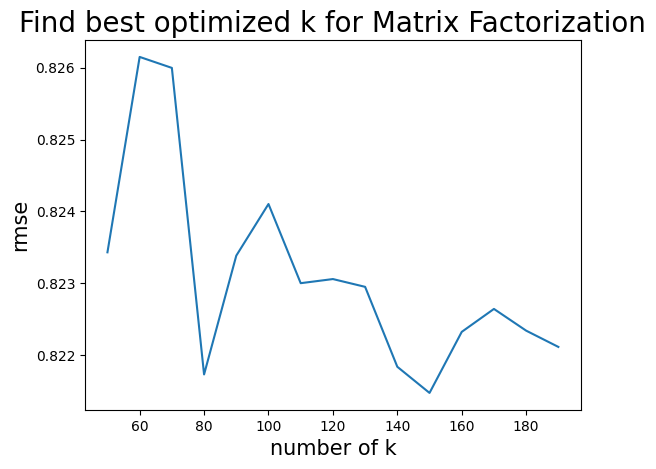

In [ ]:
plt.plot(res.index, res.rmse)
plt.title("Find best optimized k for Matrix Factorization", fontsize=20)
plt.xlabel('number of k', fontsize=15)
plt.ylabel('rmse', fontsize=15)
plt.show()

## Matrix Factorization with Simple Python module

- https://pypi.org/project/matrix-factorization/

In [ ]:
!pip install matrix-factorization

  Preparing metadata (setup.py) ... done
  Created wheel for matrix-factorization: filename=matrix_factorization-1.3-py3-none-any.whl size=16446 sha256=837b16fcb53795551c8354301a864028d869d116029af936f310c95bfba57d75
  Stored in directory: /root/.cache/pip/wheels/20/55/7a/7f55628acaf4bc0adbb5199e744d098a483e01df9adf290f2f
Successfully built matrix-factorization


In [ ]:
from matrix_factorization import BaselineModel, KernelMF, train_update_test_split

In [ ]:
path = '/content/drive/MyDrive/data/movielens'
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding='utf-8')

print(ratings_df.shape)
print(ratings_df.head())

(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [ ]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)

print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


In [ ]:
train_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [ ]:
new_train_df = train_df
new_train_df = new_train_df.rename(columns={"userId": "user_id", "movieId": "item_id"})
new_train_df.head()

,user_id,item_id,rating,timestamp
95713,600,5943,3.0,1237714356
61560,407,2571,5.0,1424349171
77204,482,8958,4.0,1105397126
93367,599,2322,2.5,1498515283
90892,590,2959,3.5,1258416553


dataset -> train valid test -> train valid : 실제 학습할때 , test :  학습된 모델의 성능을 평가할 때 사용

In [ ]:
(
    X_train_initial,
    y_train_initial,
    X_train_update,
    y_train_update,
    X_test_update,
    y_test_update,
) = train_update_test_split(new_train_df, frac_new_users=0.2)

In [ ]:
# Initial training
matrix_fact = KernelMF(n_epochs=20, n_factors=100, verbose=1, lr=0.001, reg=0.005)
matrix_fact.fit(X_train_initial, y_train_initial)

Epoch  1 / 20  -  train_rmse: 0.9832757722543578
Epoch  2 / 20  -  train_rmse: 0.9591638675136125
Epoch  3 / 20  -  train_rmse: 0.9430726103573465
Epoch  4 / 20  -  train_rmse: 0.9308711504424176
Epoch  5 / 20  -  train_rmse: 0.9210369863372139
Epoch  6 / 20  -  train_rmse: 0.912749787939037
Epoch  7 / 20  -  train_rmse: 0.9055401720922815
Epoch  8 / 20  -  train_rmse: 0.8991329383846226
Epoch  9 / 20  -  train_rmse: 0.8933386095522329
Epoch  10 / 20  -  train_rmse: 0.8880212867788064
Epoch  11 / 20  -  train_rmse: 0.8830844657972715
Epoch  12 / 20  -  train_rmse: 0.8784671054949751
Epoch  13 / 20  -  train_rmse: 0.8740878114932943
Epoch  14 / 20  -  train_rmse: 0.8699306588454379
Epoch  15 / 20  -  train_rmse: 0.8659584211618118
Epoch  16 / 20  -  train_rmse: 0.8621357614529556
Epoch  17 / 20  -  train_rmse: 0.8584466598107836
Epoch  18 / 20  -  train_rmse: 0.8548672719413374
Epoch  19 / 20  -  train_rmse: 0.8513851519179346
Epoch  20 / 20  -  train_rmse: 0.8479894249882536


KernelMF(gamma=0.01, lr=0.001, n_epochs=20, reg=0.005)

In [ ]:
# Update model with new users
matrix_fact.update_users(
    X_train_update, y_train_update, lr=0.001, n_epochs=20, verbose=1
)

Epoch  1 / 20  -  train_rmse: 0.9881636473400585
Epoch  2 / 20  -  train_rmse: 0.9673028734790828
Epoch  3 / 20  -  train_rmse: 0.952594508608628
Epoch  4 / 20  -  train_rmse: 0.941666652146564
Epoch  5 / 20  -  train_rmse: 0.9331882499423804
Epoch  6 / 20  -  train_rmse: 0.9263711441710547
Epoch  7 / 20  -  train_rmse: 0.9207171119141773
Epoch  8 / 20  -  train_rmse: 0.915899332689396
Epoch  9 / 20  -  train_rmse: 0.9117297678190603
Epoch  10 / 20  -  train_rmse: 0.9080323781759095
Epoch  11 / 20  -  train_rmse: 0.9047628148063611
Epoch  12 / 20  -  train_rmse: 0.9018078430668701
Epoch  13 / 20  -  train_rmse: 0.8991175188637026
Epoch  14 / 20  -  train_rmse: 0.8966595052383988
Epoch  15 / 20  -  train_rmse: 0.8943809975828387
Epoch  16 / 20  -  train_rmse: 0.8922619123606841
Epoch  17 / 20  -  train_rmse: 0.8902697719964198
Epoch  18 / 20  -  train_rmse: 0.8883986977886962
Epoch  19 / 20  -  train_rmse: 0.886627208065427
Epoch  20 / 20  -  train_rmse: 0.8849416981995023


In [ ]:
pred = matrix_fact.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared=False)
print(f"\nTest RMSE: {rmse:.4f}")


Test RMSE: 0.9113


In [ ]:
# Get recommendations
user = 200
items_known = X_train_initial.query("user_id == @user")["item_id"]
matrix_fact.recommend(user=user, items_known=items_known)

,user_id,item_id,rating_pred
270,200,260,4.541392
509,200,912,4.462461
218,200,1196,4.458404
45,200,1210,4.396763
185,200,527,4.376641
125,200,858,4.375171
974,200,750,4.367256
101,200,110,4.350993
141,200,904,4.325664
337,200,541,4.319330


### SGD

In [ ]:
baseline_model = BaselineModel(method='sgd', n_epochs = 20, reg = 0.005, lr = 0.01, verbose=1)
baseline_model.fit(X_train_initial, y_train_initial)

pred = baseline_model.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared = False)

print(f'\nTest RMSE: {rmse:.4f}')

Epoch  1 / 20  -  train_rmse: 0.9010147572103905
Epoch  2 / 20  -  train_rmse: 0.8771788936852759
Epoch  3 / 20  -  train_rmse: 0.8639970667093433
Epoch  4 / 20  -  train_rmse: 0.8540957917270663
Epoch  5 / 20  -  train_rmse: 0.8468328768087936
Epoch  6 / 20  -  train_rmse: 0.8412754075310883
Epoch  7 / 20  -  train_rmse: 0.8366429499242276
Epoch  8 / 20  -  train_rmse: 0.8326340884984554
Epoch  9 / 20  -  train_rmse: 0.8292945691535363
Epoch  10 / 20  -  train_rmse: 0.8262796823980431
Epoch  11 / 20  -  train_rmse: 0.823622127464131
Epoch  12 / 20  -  train_rmse: 0.8210375663935632
Epoch  13 / 20  -  train_rmse: 0.8188945952323295
Epoch  14 / 20  -  train_rmse: 0.8168727770756842
Epoch  15 / 20  -  train_rmse: 0.8152856779002264
Epoch  16 / 20  -  train_rmse: 0.8131455354841747
Epoch  17 / 20  -  train_rmse: 0.8116529622348385
Epoch  18 / 20  -  train_rmse: 0.810441801740245
Epoch  19 / 20  -  train_rmse: 0.808907845017422
Epoch  20 / 20  -  train_rmse: 0.8077700702379381

Test RMSE: 

In [ ]:
%%time
baseline_model.update_users(X_train_update, y_train_update, n_epochs=20, lr=0.001, verbose=1)
pred = baseline_model.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared = False)

print(f'\nTest RMSE: {rmse:.4f}')

Epoch  1 / 20  -  train_rmse: 0.9557257109158848
Epoch  2 / 20  -  train_rmse: 0.9351052781898007
Epoch  3 / 20  -  train_rmse: 0.9206767994582602
Epoch  4 / 20  -  train_rmse: 0.9102706737462513
Epoch  5 / 20  -  train_rmse: 0.9023472745535555
Epoch  6 / 20  -  train_rmse: 0.8961854367719848
Epoch  7 / 20  -  train_rmse: 0.891240544394916
Epoch  8 / 20  -  train_rmse: 0.8871732455979319
Epoch  9 / 20  -  train_rmse: 0.8837971884505671
Epoch  10 / 20  -  train_rmse: 0.8809469934546598
Epoch  11 / 20  -  train_rmse: 0.878520900942977
Epoch  12 / 20  -  train_rmse: 0.8764231649345148
Epoch  13 / 20  -  train_rmse: 0.8746159957235453
Epoch  14 / 20  -  train_rmse: 0.8730426890718095
Epoch  15 / 20  -  train_rmse: 0.8716562442036029
Epoch  16 / 20  -  train_rmse: 0.8704375524999489
Epoch  17 / 20  -  train_rmse: 0.8693529595036973
Epoch  18 / 20  -  train_rmse: 0.868379405882877
Epoch  19 / 20  -  train_rmse: 0.8675042084616261
Epoch  20 / 20  -  train_rmse: 0.8667163769191136

Test RMSE: 

### ALS

In [ ]:
baseline_model = BaselineModel(method='als', n_epochs = 20, reg = 0.5, verbose=1)
baseline_model.fit(X_train_initial, y_train_initial)

pred = baseline_model.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared = False)

print(f'\nTest RMSE: {rmse:.4f}')

Epoch  1 / 20  -  train_rmse: 0.7957625573224865
Epoch  2 / 20  -  train_rmse: 0.7796195167434012
Epoch  3 / 20  -  train_rmse: 0.7781753328408155
Epoch  4 / 20  -  train_rmse: 0.7779487685807952
Epoch  5 / 20  -  train_rmse: 0.7778893117878165
Epoch  6 / 20  -  train_rmse: 0.7778639761550039
Epoch  7 / 20  -  train_rmse: 0.7778476991331194
Epoch  8 / 20  -  train_rmse: 0.7778345939275833
Epoch  9 / 20  -  train_rmse: 0.7778230994667006
Epoch  10 / 20  -  train_rmse: 0.7778127360197974
Epoch  11 / 20  -  train_rmse: 0.7778033102427465
Epoch  12 / 20  -  train_rmse: 0.7777947108229084
Epoch  13 / 20  -  train_rmse: 0.7777868542627395
Epoch  14 / 20  -  train_rmse: 0.777779669839862
Epoch  15 / 20  -  train_rmse: 0.777773095007188
Epoch  16 / 20  -  train_rmse: 0.7777670736570124
Epoch  17 / 20  -  train_rmse: 0.7777615552175408
Epoch  18 / 20  -  train_rmse: 0.7777564940246355
Epoch  19 / 20  -  train_rmse: 0.7777518488101931
Epoch  20 / 20  -  train_rmse: 0.7777475822580044

Test RMSE: